# HRTEM simulation from charge density

This notebook demonstrates how simulate HRTEM images using a potential created calculated from the all-electron density of a DFT calculation.

In [1]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from ase.io import read
from pyqstem.util import atoms_plot
from pyqstem import PyQSTEM
from pyqstem.potentials import poisson_solver,create_potential_slices
mpl.rc('font',**{'size' : 13})

Import all-electron density and the corresponding atomic configuration.

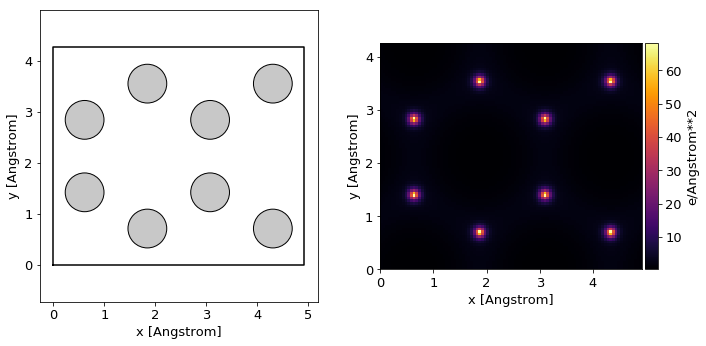

Total charge (in elementary charges): 47.9999438247


In [2]:
rho=np.load('graphene.npy') # all-electron density from GPAW using LDA
atoms=read('graphene.cif',index=0) # atomic configuration

Lx,Ly,Lz=np.diag(atoms.get_cell())
Nx,Ny,Nz=rho.shape

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
atoms_plot(atoms,ax=ax1,scale_atoms=.5)
im=ax2.imshow(np.trapz(rho,dx=Lz/Nz,axis=2).T,extent=[0,Lx,0,Ly],cmap='inferno')
ax2.set_xlabel('x [Angstrom]')
ax2.set_ylabel('y [Angstrom]')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax2,label='e/Angstrom**2')
plt.tight_layout()
plt.show()

print('Total charge (in elementary charges):',np.sum(rho*Lx*Ly*Lz/(Nx*Ny*Nz)))

We solve the Poisson equation for the all electron charge distribution and ions placed at the atomic positions. The solution is found using the spectral method(https://en.wikipedia.org/wiki/Spectral_method) and hence assumes periodic boundary conditions.

In [3]:
V=poisson_solver(rho,atoms,smooth=0,units='QSTEM')
V_dft=create_potential_slices(V,10,(Lx,Ly,Lz))

For comparison we will also create and import a potential from QSTEM.

In [4]:
qstem=PyQSTEM('TEM')
qstem.set_atoms(atoms)
qstem.build_wave('plane',300,(Nx,Ny))
qstem.build_potential(10)
V_qstem=qstem.get_potential_or_transfunc()
qstem.run()
wave_qstem=qstem.get_wave()

We plot the potential from DFT and QSTEM for comparison, they are quite similar. The DFT potential have some artifacts, this is 'ringing'(https://en.wikipedia.org/wiki/Ringing_artifacts) due to finite truncation of the Fourier series, this could be solved by implementing a smoother truncation.

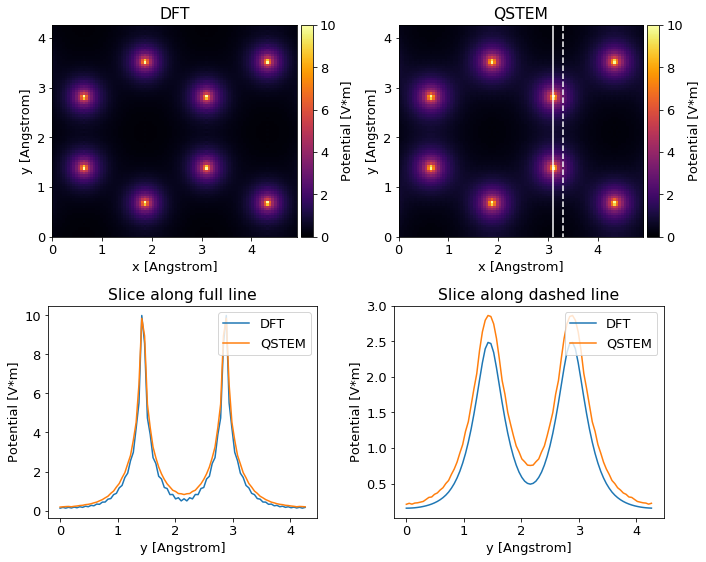

In [9]:
line1_x=3.1
line2_x=3.3

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,8))
im1=ax1.imshow(np.sum(V_dft.array.real,axis=2).T,extent=[0,Lx,0,Ly],cmap='inferno',vmin=0,vmax=10)
ax1.set_xlabel('x [Angstrom]')
ax1.set_ylabel('y [Angstrom]')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1,cax=cax1,label='Potential [V*m]')
ax1.set_title('DFT')

ax2.plot([line1_x,line1_x],[-1,Ly+1],'w-')
ax2.plot([line2_x,line2_x],[-1,Ly+1],'w--')
im2=ax2.imshow(np.sum(V_qstem.array.real,axis=2).T,extent=[0,Lx,0,Ly],cmap='inferno',vmin=0,vmax=10)
ax2.set_xlabel('x [Angstrom]')
ax2.set_ylabel('y [Angstrom]')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2,cax=cax2,label='Potential [V*m]')
ax2.set_title('QSTEM')

ax3.plot(np.linspace(0,Ly,Ny),np.sum(V_dft.array.real,axis=2)[int(line1_x/Lx*Nx),:],label='DFT')
ax3.plot(np.linspace(0,Ly,Ny),np.sum(V_qstem.array.real,axis=2)[int(line1_x/Lx*Nx),:],label='QSTEM')
ax3.legend(prop={'size':13},loc='upper right')
ax3.set_xlabel('y [Angstrom]')
ax3.set_ylabel('Potential [V*m]')
ax3.set_title('Slice along full line')

ax4.plot(np.linspace(0,Ly,Ny),np.sum(V_dft.array.real,axis=2)[int(line2_x/Lx*Nx),:],label='DFT')
ax4.plot(np.linspace(0,Ly,Ny),np.sum(V_qstem.array.real,axis=2)[int(line2_x/Lx*Nx),:],label='QSTEM')
ax4.legend(prop={'size':13},loc='upper right')
ax4.set_xlabel('y [Angstrom]')
ax4.set_ylabel('Potential [V*m]')
ax4.set_title('Slice along dashed line')

plt.tight_layout()
plt.show()

Finally, we propagate a plane wave through the DFT potential and compare the results.

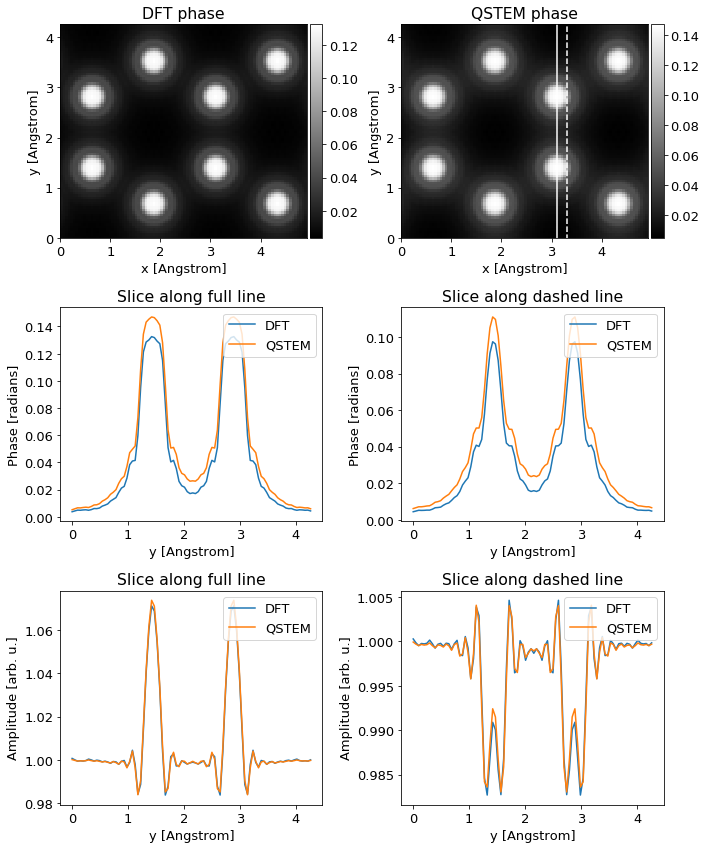

In [10]:
qstem.build_wave('plane',300,(Nx,Ny))
qstem.set_potential(V_dft)
qstem.run()
wave_dft=qstem.get_wave()

line1_x=3.1
line2_x=3.3

fig,((ax1,ax2),(ax3,ax4),(ax5,ax6))=plt.subplots(3,2,figsize=(10,12))
wave_dft.view(ax=ax1,method='phase',title='DFT phase')
ax2.plot([line1_x,line1_x],[-1,Ly+1],'w-')
ax2.plot([line2_x,line2_x],[-1,Ly+1],'w--')
wave_qstem.view(ax=ax2,method='phase',title='QSTEM phase')

ax3.plot(np.linspace(0,Ly,Ny),np.angle(wave_dft.array)[int(line1_x/Lx*Nx),:],label='DFT')
ax3.plot(np.linspace(0,Ly,Ny),np.angle(wave_qstem.array)[int(line1_x/Lx*Nx),:],label='QSTEM')
ax3.legend(prop={'size':13},loc='upper right')
ax3.set_xlabel('y [Angstrom]')
ax3.set_ylabel('Phase [radians]')
ax3.set_title('Slice along full line')

ax4.plot(np.linspace(0,Ly,Ny),np.angle(wave_dft.array)[int(line2_x/Lx*Nx),:],label='DFT')
ax4.plot(np.linspace(0,Ly,Ny),np.angle(wave_qstem.array)[int(line2_x/Lx*Nx),:],label='QSTEM')
ax4.legend(prop={'size':13},loc='upper right')
ax4.set_xlabel('y [Angstrom]')
ax4.set_ylabel('Phase [radians]')
ax4.set_title('Slice along dashed line')

ax5.plot(np.linspace(0,Ly,Ny),np.abs(wave_dft.array)[int(line1_x/Lx*Nx),:],label='DFT')
ax5.plot(np.linspace(0,Ly,Ny),np.abs(wave_qstem.array)[int(line1_x/Lx*Nx),:],label='QSTEM')
ax5.legend(prop={'size':13},loc='upper right')
ax5.set_xlabel('y [Angstrom]')
ax5.set_ylabel('Amplitude [arb. u.]')
ax5.set_title('Slice along full line')

ax6.plot(np.linspace(0,Ly,Ny),np.abs(wave_dft.array)[int(line2_x/Lx*Nx),:],label='DFT')
ax6.plot(np.linspace(0,Ly,Ny),np.abs(wave_qstem.array)[int(line2_x/Lx*Nx),:],label='QSTEM')
ax6.legend(prop={'size':13},loc='upper right')
ax6.set_xlabel('y [Angstrom]')
ax6.set_ylabel('Amplitude [arb. u.]')
ax6.set_title('Slice along dashed line')

plt.tight_layout()